<a href="https://colab.research.google.com/github/johanjun/Google_Machine_Learning_Bootcamp_KR_2021/blob/main/kaggle/RSNA_MICCAI_BRAIN_TUMOR/rsna_miccai_brain_tumor_johanjun_0919(ensemble).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install pydicom

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import random
import pydicom
import cv2
import pickle

import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [8]:
data_dir = '/content/drive/MyDrive/RSNA_MICCAI/data/rsna-miccai/'

In [9]:
train_df = pd.read_csv(data_dir + "train_labels.csv")
test_df = pd.read_csv(data_dir + "sample_submission.csv")

In this discussion a competition host has notified that there are some issues with these 3 cases
Patient IDs -

1. 00109 (FLAIR images are blank)
2. 00123 (T1w images are blank)
3. 00709 (FLAIR images are blank)
<br><br>Hence these can be excluded

In [10]:
#refer: https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
EXCLUDE = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [11]:
TYPES = ["FLAIR", "T1w", "T1wCE", "T2w"] #mpMRI scans

In [12]:
def load_dicom(path, size = 64): #load DICOM files
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array #returns a numpy.ndarray containing the pixel data
    if np.max(data) != 0:
        data = data / np.max(data) #standardizes so that the pixel values are between 0 and 1
    data = (data * 255).astype(np.uint8) #rescales to 0 and 255
    return cv2.resize(data, (size, size))

In [13]:
def get_all_image_paths(BraTS21ID, image_type, folder="train"): #get an array of all the images of a particular type or a particular patient id
    assert(image_type in TYPES) #only in types
    patient_path = os.path.join(data_dir + "%s/" % folder, str(BraTS21ID).zfill(5)) #다른 폴더일 수도 있음
    #print(lambda x: int(x[:-4].split("-")[-1]))
    
    paths = sorted(glob.glob(os.path.join(patient_path, image_type, "*")), key=lambda x: int(x[:-4].split("-")[-1])) #sort
    #print(paths)
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    if num_images < 10:
        jump = 1
    else:
        jump = 3
        
    return np.array(paths[start:end:jump])

In [14]:
def get_all_images(BraTS21ID, image_type, folder="train", size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(BraTS21ID, image_type, folder)]

In [15]:
def get_all_data_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        tmp_x = train_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "train", IMAGE_SIZE)
        label = tmp_x["MGMT_value"]

        X += images
        y += [label] * len(images)
        train_ids += [int(tmp_x["BraTS21ID"])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        tmp_x = test_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "test", IMAGE_SIZE)
        X += images
        test_ids += [int(tmp_x["BraTS21ID"])] * len(images)

    return np.array(X), np.array(test_ids)

In [19]:
#pickling
with open(data_dir+'X_T1wCE.pkl', 'rb') as f:
  X_T1wCE = pickle.load(f)

with open(data_dir+'y_T1wCE.pkl', 'rb') as f:
  y_T1wCE = pickle.load(f)

with open(data_dir+'train_idt_T1wCE.pkl', 'rb') as f:
  train_idt_T1wCE = pickle.load(f)

with open(data_dir+'X_test_T1wCE.pkl', 'rb') as f:
  X_test_T1wCE = pickle.load(f)

with open(data_dir+'test_idt_T1wCE.pkl', 'rb') as f:
  X_test_T1wCE = pickle.load(f)

In [20]:
#pickling
with open(data_dir+'X_FLAIR.pkl', 'rb') as f:
  X_FLAIR = pickle.load(f)

with open(data_dir+'y_FLAIR.pkl', 'rb') as f:
  y_FLAIR = pickle.load(f)

with open(data_dir+'train_idt_FLAIR.pkl', 'rb') as f:
  train_idt_FLAIR = pickle.load(f)

with open(data_dir+'X_test_FLAIR.pkl', 'rb') as f:
  X_test_FLAIR = pickle.load(f)

with open(data_dir+'test_idt_FLAIR.pkl', 'rb') as f:
  X_test_FLAIR = pickle.load(f)

In [25]:
#pickling
with open(data_dir+'X_T2w.pkl', 'rb') as f:
  X_T2w = pickle.load(f)

with open(data_dir+'y_T2w.pkl', 'rb') as f:
  y_T2w = pickle.load(f)

with open(data_dir+'train_idt_T2w.pkl', 'rb') as f:
  train_idt_T2w = pickle.load(f)

with open(data_dir+'X_test_T2w.pkl', 'rb') as f:
  X_test_T2w = pickle.load(f)

with open(data_dir+'test_idt_T2w.pkl', 'rb') as f:
  X_test_T2w = pickle.load(f)

In [26]:
#pickling
with open(data_dir+'X_T1w.pkl', 'rb') as f:
  X_T1w = pickle.load(f)

with open(data_dir+'y_T1w.pkl', 'rb') as f:
  y_T1w = pickle.load(f)

with open(data_dir+'train_idt_T1w.pkl', 'rb') as f:
  train_idt_T1w = pickle.load(f)

with open(data_dir+'X_test_T1w.pkl', 'rb') as f:
  X_test_T1w = pickle.load(f)

with open(data_dir+'test_idt_T1w.pkl', 'rb') as f:
  X_test_T1w = pickle.load(f)

In [32]:
print(X_T1wCE.shape, y_T1wCE.shape, train_idt_T1wCE.shape)
print(X_FLAIR.shape, y_FLAIR.shape, train_idt_FLAIR.shape)
print(X_T2w.shape, y_T2w.shape, train_idt_T2w.shape)
print(X_T1w.shape, y_T1w.shape, train_idt_T1w.shape)

(16196, 64, 64) (16196,) (16196,)
(12463, 64, 64) (12463,) (12463,)
(16813, 64, 64) (16813,) (16813,)
(13004, 64, 64) (13004,) (13004,)


In [ ]:
# X = np.concatenate([X_FLAIR, X_T1wCE, X_T2w, X_T1w], axis=0)
# y = np.concatenate([y_FLAIR, y_T1wCE, y_T2w, y_T1w], axis=0)
# train_idt = np.concatenate([train_idt_FLAIR, train_idt_T1wCE, train_idt_T2w, train_idt_T1w], axis=0)

# X_test = np.concatenate([X_test_FLAIR, X_test_T1wCE, X_test_T2w, X_test_T1w], axis=0)
# test_idt = np.concatenate([test_idt_FLAIR, test_idt_T1wCE, test_idt_T2w, test_idt_T1w], axis=0)

In [39]:
from tensorflow.keras.applications import EfficientNetB0
model1 = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), weights=None, classes=2)
model2 = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), weights=None, classes=2)
model3 = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), weights=None, classes=2)
model4 = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), weights=None, classes=2)

In [62]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X_T1wCE, y_T1wCE, train_idt_T1wCE, test_size=0.15)

X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

In [36]:
N_EPOCHS = 10
N_BATCH = 40
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [40]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])

history = model1.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/10
344/344 [==============================] - 47s 61ms/step - loss: 1.8647 - auc_1: 0.5020 - val_loss: 0.7191 - val_auc_1: 0.5554
Epoch 2/10
344/344 [==============================] - 18s 53ms/step - loss: 1.6691 - auc_1: 0.5168 - val_loss: 0.7267 - val_auc_1: 0.5584
Epoch 3/10
344/344 [==============================] - 18s 53ms/step - loss: 1.5040 - auc_1: 0.5156 - val_loss: 1.1966 - val_auc_1: 0.5489
Epoch 4/10
344/344 [==============================] - 18s 53ms/step - loss: 1.3523 - auc_1: 0.5278 - val_loss: 1.2020 - val_auc_1: 0.5457
Epoch 5/10
344/344 [==============================] - 18s 53ms/step - loss: 1.2579 - auc_1: 0.5304 - val_loss: 0.9860 - val_auc_1: 0.5505
Epoch 6/10
344/344 [==============================] - 18s 53ms/step - loss: 1.1439 - auc_1: 0.5286 - val_loss: 2.8439 - val_auc_1: 0.5522
Epoch 7/10
344/344 [==============================] - 18s 53ms/step - loss: 1.1136 - auc_1: 0.5422 - val_loss: 1.6119 - val_auc_1: 0.5543
Epoch 8/10
344/344 [==============

In [41]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X_FLAIR, y_FLAIR, train_idt_FLAIR, test_size=0.15)

X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

In [42]:
N_EPOCHS = 10
N_BATCH = 40
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [43]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])

history = model2.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/10
264/264 [==============================] - 24s 63ms/step - loss: 1.9232 - auc_2: 0.5361 - val_loss: 0.7486 - val_auc_2: 0.3831
Epoch 2/10
264/264 [==============================] - 14s 54ms/step - loss: 1.6413 - auc_2: 0.5610 - val_loss: 0.6816 - val_auc_2: 0.6023
Epoch 3/10
264/264 [==============================] - 14s 54ms/step - loss: 1.5508 - auc_2: 0.5514 - val_loss: 0.9251 - val_auc_2: 0.6280
Epoch 4/10
264/264 [==============================] - 14s 54ms/step - loss: 1.4377 - auc_2: 0.5610 - val_loss: 0.9373 - val_auc_2: 0.5994
Epoch 5/10
264/264 [==============================] - 14s 53ms/step - loss: 1.3608 - auc_2: 0.5605 - val_loss: 0.9588 - val_auc_2: 0.4834
Epoch 6/10
264/264 [==============================] - 14s 53ms/step - loss: 1.2745 - auc_2: 0.5665 - val_loss: 0.9074 - val_auc_2: 0.6208
Epoch 7/10
264/264 [==============================] - 14s 53ms/step - loss: 1.1805 - auc_2: 0.5712 - val_loss: 0.8255 - val_auc_2: 0.5599
Epoch 8/10
264/264 [==============

In [44]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X_T2w, y_T2w, train_idt_T2w, test_size=0.15)

X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

In [45]:
N_EPOCHS = 10
N_BATCH = 40
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [46]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])

history = model3.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/10
357/357 [==============================] - 28s 59ms/step - loss: 1.9996 - auc_3: 0.5243 - val_loss: 0.7002 - val_auc_3: 0.5913
Epoch 2/10
357/357 [==============================] - 19s 53ms/step - loss: 1.6281 - auc_3: 0.5448 - val_loss: 0.9292 - val_auc_3: 0.6060
Epoch 3/10
357/357 [==============================] - 19s 53ms/step - loss: 1.5409 - auc_3: 0.5517 - val_loss: 1.2666 - val_auc_3: 0.6085
Epoch 4/10
357/357 [==============================] - 19s 53ms/step - loss: 1.3200 - auc_3: 0.5664 - val_loss: 1.1909 - val_auc_3: 0.6090
Epoch 5/10
357/357 [==============================] - 19s 53ms/step - loss: 1.2196 - auc_3: 0.5658 - val_loss: 0.8919 - val_auc_3: 0.6054
Epoch 6/10
357/357 [==============================] - 19s 53ms/step - loss: 1.1350 - auc_3: 0.5749 - val_loss: 0.7828 - val_auc_3: 0.6016
Epoch 7/10
357/357 [==============================] - 19s 53ms/step - loss: 1.0735 - auc_3: 0.5789 - val_loss: 0.9011 - val_auc_3: 0.6235
Epoch 8/10
357/357 [==============

In [47]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X_T1w, y_T1w, train_idt_T1w, test_size=0.15)

X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

In [48]:
N_EPOCHS = 10
N_BATCH = 40
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [49]:
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])

history = model4.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/10
276/276 [==============================] - 24s 62ms/step - loss: 2.0483 - auc_4: 0.5039 - val_loss: 0.6948 - val_auc_4: 0.5550
Epoch 2/10
276/276 [==============================] - 15s 53ms/step - loss: 1.6854 - auc_4: 0.5294 - val_loss: 0.7441 - val_auc_4: 0.4560
Epoch 3/10
276/276 [==============================] - 15s 53ms/step - loss: 1.5947 - auc_4: 0.5329 - val_loss: 0.7113 - val_auc_4: 0.5879
Epoch 4/10
276/276 [==============================] - 15s 52ms/step - loss: 1.4061 - auc_4: 0.5432 - val_loss: 0.9519 - val_auc_4: 0.5172
Epoch 5/10
276/276 [==============================] - 15s 53ms/step - loss: 1.2773 - auc_4: 0.5441 - val_loss: 0.8547 - val_auc_4: 0.5729
Epoch 6/10
276/276 [==============================] - 15s 53ms/step - loss: 1.2307 - auc_4: 0.5586 - val_loss: 1.0014 - val_auc_4: 0.5873
Epoch 7/10
276/276 [==============================] - 15s 53ms/step - loss: 1.1733 - auc_4: 0.5503 - val_loss: 0.8855 - val_auc_4: 0.5739
Epoch 8/10
276/276 [==============

In [69]:
input_shape = X_train[0,:,:,:].shape
model_input = Input(shape=input_shape)

In [100]:
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average

def conv_model(model_input):
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(2, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)

    model = Model(model_input, x, name='conv_model')
    
    return model

In [101]:
model1_T1wCE = conv_model(model_input)

In [104]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10

import numpy as np
N_EPOCHS = 10
N_BATCH = 40
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))
def compile_and_train(model, num_epochs): 
    
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['acc']) 
    filepath = data_dir+'weights/' + model.name + '.{epoch:02d}-{loss:.2f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_weights_only=True, save_best_only=True, mode='auto', period=1)
    tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=32)
    history = model.fit(x=X_train, y=y_train, batch_size=40, epochs=N_EPOCHS, verbose=1, callbacks=[checkpoint, tensor_board], validation_split=0.2)
    return history

In [105]:
_ = compile_and_train(model1_T1wCE, num_epochs=20)

Epoch 1/10
276/276 [==============================] - 19s 65ms/step - loss: 0.6904 - acc: 0.5365 - val_loss: 0.6894 - val_acc: 0.5421
Epoch 2/10
276/276 [==============================] - 17s 63ms/step - loss: 0.6896 - acc: 0.5405 - val_loss: 0.6879 - val_acc: 0.5421
Epoch 3/10
276/276 [==============================] - 18s 64ms/step - loss: 0.6899 - acc: 0.5383 - val_loss: 0.6894 - val_acc: 0.5657
Epoch 4/10
276/276 [==============================] - 18s 65ms/step - loss: 0.6865 - acc: 0.5459 - val_loss: 0.6825 - val_acc: 0.5606
Epoch 5/10
191/276 [===================>..........] - ETA: 5s - loss: 0.6822 - acc: 0.5643

KeyboardInterrupt: ignored

In [52]:
#ensemble
models = [model1, model2, model3, model4]

In [53]:
def ensemble(models, model_input):
    
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model

In [54]:
ensemble_model = ensemble(models, model_input)

NameError: ignored

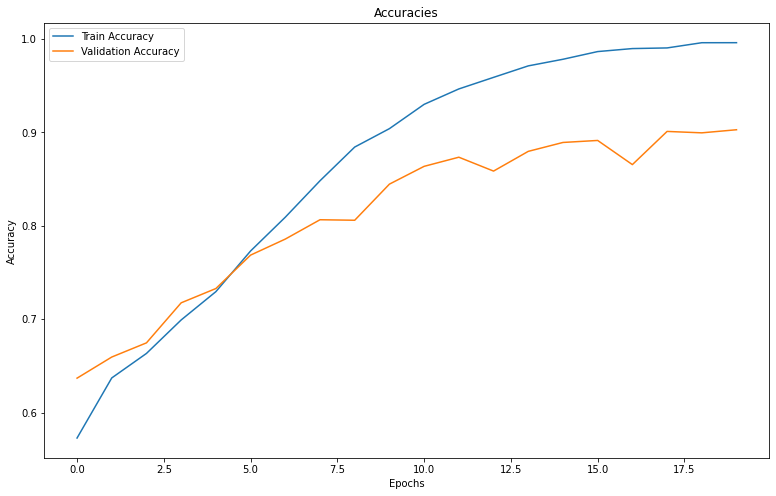

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_1"], label = "Train Accuracy")
plt.plot(history.history["val_auc_1"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

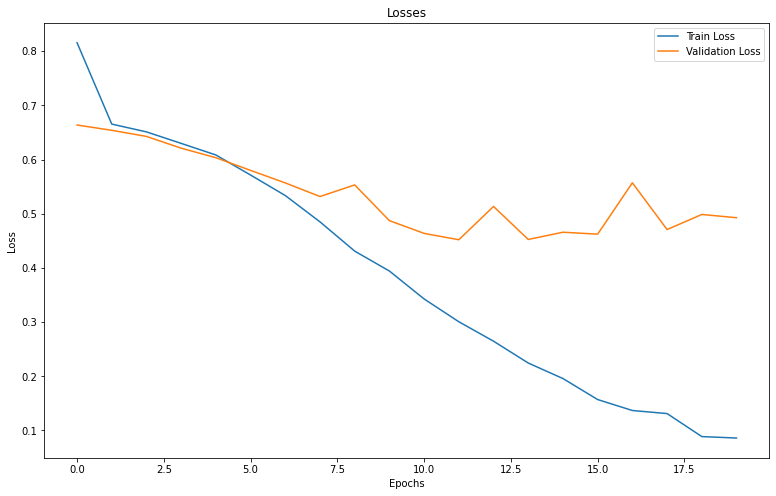

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_valid) #pedict on X_valid
pred = np.argmax(y_pred, axis = 1) #index of largest value by column 열 기준 가장 큰 값의 인덱스

result = pd.DataFrame(train_idt_valid) #BraTS21ID
result[1] = pred #MGMT_value
result.columns=["BraTS21ID","MGMT_value"]

In [ ]:
#Group by BraTS21ID and average + do not use index
result_final = result.groupby("BraTS21ID", as_index = False).mean()
result_final = result_final.merge(train_df, on = "BraTS21ID") #merge train_df

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(result_final.MGMT_value_y, result_final.MGMT_value_x,)

0.8553917462444854

In [ ]:
X_test2 = tf.expand_dims(X_test, axis=-1)

In [ ]:
#submission
sample_sub = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

y_pred = model.predict(X_test2) #predict test
pred = np.argmax(y_pred, axis = 1)

result = pd.DataFrame(test_idt)
result[1] = pred

result.columns=["BraTS21ID","MGMT_value"]
result_final = result.groupby("BraTS21ID",as_index = False).mean()

result_final["BraTS21ID"] = sample_sub["BraTS21ID"]
result_final["MGMT_value"] = result_final["MGMT_value"]
result_final

,BraTS21ID,MGMT_value
0,1,0.909091
1,13,0.909091
2,15,0.901961
3,27,0.921569
4,37,0.954545
...,...,...
82,826,0.857143
83,829,0.800000
84,833,0.375000
85,997,0.500000


In [ ]:
result_final.to_csv("submission.csv",index=False)